# NOTA PARA EL LECTOR
Este notebook tiene como objetivo crear varios modelos de aprendizaje automático para predecir la temperatura máxima diaria en Sevilla ciudad. Se han desarrollado un total de 5 modelos de redes neuronales y un modelo ingenuo para comparar su rendimiento.

- El conjunto de datos consiste en datos meteorológicos diarios de la ciudad de Sevilla desde el 1 de enero de 1983 hasta el 1 de enero de 2023.
- Los datos de entrada de los modelos serán el mes (`MO`), la temperatura mínima (`T2M_MIN`) y la temperatura máxima (`T2M_MAX`) diaria en Sevilla. Se utilizarán los datos de los últimos 90 días para predecir la temperatura máxima del día siguiente.
- Antes de construir los modelos, se realizará un breve análisis de las series temporales.


## FUENTE DE LOS DATOS: https://power.larc.nasa.gov/data-access-viewer/

In [1]:
# Importar las librerías básicas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# PREPROCESADO Y ANÁLISIS

## 1- Importar el dataset y darle la forma deseada. 

In [2]:
dataset = pd.read_csv("Datos_Benito_Villamarin.csv", sep = ';')
dataset

YEAR  MO  DY  T2M_MAX  T2M_MIN  PRECTOTCORR      PS
0      1983   1   1    14.24     0.69         0.00  100.87
1      1983   1   2    13.11    -1.12         0.00  101.00
2      1983   1   3    13.94     0.01         0.00  101.14
3      1983   1   4    16.24     0.91         0.00  101.23
4      1983   1   5    17.07     3.06         0.00  101.09
...     ...  ..  ..      ...      ...          ...     ...
14606  2022  12  28    19.92     7.19         0.00  100.36
14607  2022  12  29    17.58     7.56         0.03  100.32
14608  2022  12  30    18.35     8.64         0.12  100.39
14609  2022  12  31    17.90     4.55         0.00  100.30
14610  2023   1   1    19.47     7.50         0.85  100.04

[14611 rows x 7 columns]

In [3]:
dataset = dataset.iloc[:, [0, 1, 2, 3, 4]]
dataset

YEAR  MO  DY  T2M_MAX  T2M_MIN
0      1983   1   1    14.24     0.69
1      1983   1   2    13.11    -1.12
2      1983   1   3    13.94     0.01
3      1983   1   4    16.24     0.91
4      1983   1   5    17.07     3.06
...     ...  ..  ..      ...      ...
14606  2022  12  28    19.92     7.19
14607  2022  12  29    17.58     7.56
14608  2022  12  30    18.35     8.64
14609  2022  12  31    17.90     4.55
14610  2023   1   1    19.47     7.50

[14611 rows x 5 columns]

A continuación se creará una variable `DATE` tipo datetime para controlar las fechas diarias con una sola variable

In [4]:
dataset["DATE"] = pd.to_datetime(dataset["YEAR"].astype(str) + "-" + 
                                  dataset["MO"].astype(str) + "-" + 
                                  dataset["DY"].astype(str), 
                                  format="%Y-%m-%d").dt.date

dataset.insert(0, "DATE", dataset.pop("DATE"))
dataset

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7632\361551939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["DATE"] = pd.to_datetime(dataset["YEAR"].astype(str) + "-" +


DATE  YEAR  MO  DY  T2M_MAX  T2M_MIN
0      1983-01-01  1983   1   1    14.24     0.69
1      1983-01-02  1983   1   2    13.11    -1.12
2      1983-01-03  1983   1   3    13.94     0.01
3      1983-01-04  1983   1   4    16.24     0.91
4      1983-01-05  1983   1   5    17.07     3.06
...           ...   ...  ..  ..      ...      ...
14606  2022-12-28  2022  12  28    19.92     7.19
14607  2022-12-29  2022  12  29    17.58     7.56
14608  2022-12-30  2022  12  30    18.35     8.64
14609  2022-12-31  2022  12  31    17.90     4.55
14610  2023-01-01  2023   1   1    19.47     7.50

[14611 rows x 6 columns]

## 2- Análisis previo del dataset

In [5]:
dataset.dtypes

DATE        object
YEAR         int64
MO           int64
DY           int64
T2M_MAX    float64
T2M_MIN    float64
dtype: object

In [6]:
dataset.isna().any().any()

False

No hay valores nulos

In [7]:
dataset.describe()

YEAR            MO            DY       T2M_MAX       T2M_MIN
count  14611.000000  14611.000000  14611.000000  14611.000000  14611.000000
mean    2002.501061      6.522552     15.728629     24.897223     11.481236
std       11.544613      3.449006      8.800936     16.996523     15.758233
min     1983.000000      1.000000      1.000000   -999.000000   -999.000000
25%     1992.500000      4.000000      8.000000     17.640000      6.660000
50%     2003.000000      7.000000     16.000000     23.660000     11.150000
75%     2012.500000     10.000000     23.000000     32.680000     17.080000
max     2023.000000     12.000000     31.000000     46.260000     28.270000

<AxesSubplot: xlabel='T2M_MAX'>

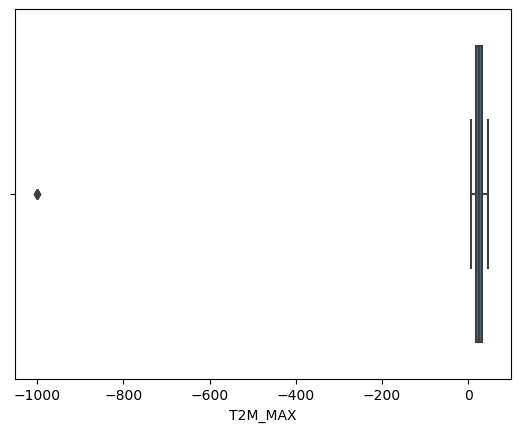

In [8]:
sns.boxplot(x=dataset["T2M_MAX"])

<AxesSubplot: xlabel='T2M_MIN'>

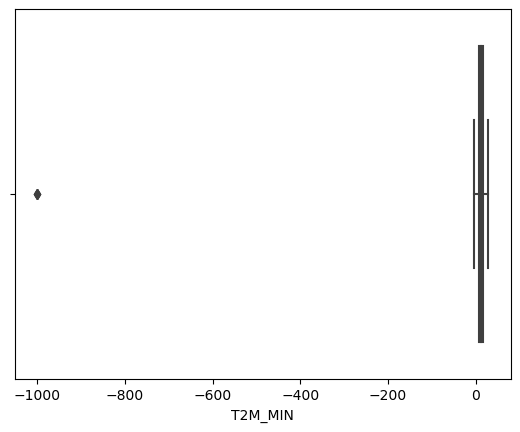

In [9]:
sns.boxplot(x=dataset["T2M_MIN"])

Se puede observar que hay, al menos, un valor atípico

### Calcular los límites de los valores atípicos en la temperatura máxima

In [10]:
q1 = np.percentile(dataset["T2M_MAX"], 25)
q3 = np.percentile(dataset["T2M_MAX"], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

##### Identificar los valores atípicos

In [11]:
outliers = dataset[(dataset["T2M_MAX"] < lower_limit) | (dataset["T2M_MAX"] > upper_limit)]
outliers

DATE  YEAR  MO  DY  T2M_MAX  T2M_MIN
14566  2022-11-18  2022  11  18   -999.0   -999.0
14567  2022-11-19  2022  11  19   -999.0   -999.0
14568  2022-11-20  2022  11  20   -999.0   -999.0

Los valores atípicos están los 3 juntos en las filas 14566, 14567 y 14568

##### Interpolar linealmente para sustituir estos 3 valores atípicos

In [12]:
first = dataset.iloc[14565, :]['T2M_MAX']
last = dataset.iloc[14569, :]['T2M_MAX']

for i in range(1,4):
    dataset.loc[14565 + i, 'T2M_MAX'] = first + (i/4)*(last - first)

<AxesSubplot: xlabel='T2M_MAX'>

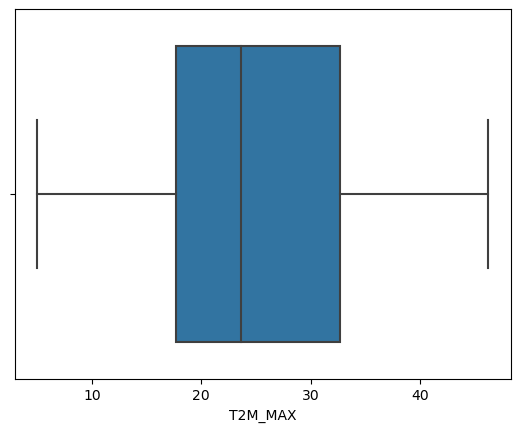

In [13]:
sns.boxplot(x=dataset["T2M_MAX"])

Ya no hay valores atípicos en la temperatura máxima

### Calcular los límites de los valores atípicos en la temperatura mínima

In [14]:
q1 = np.percentile(dataset["T2M_MIN"], 25)
q3 = np.percentile(dataset["T2M_MIN"], 75)
iqr = q3 - q1
lower_limit = q1 - 1.5*iqr
upper_limit = q3 + 1.5*iqr

##### Identificar los valores atípicos

In [15]:
outliers = dataset[(dataset["T2M_MIN"] < lower_limit) | (dataset["T2M_MIN"] > upper_limit)]
outliers

DATE  YEAR  MO  DY  T2M_MAX  T2M_MIN
14566  2022-11-18  2022  11  18   22.055   -999.0
14567  2022-11-19  2022  11  19   21.620   -999.0
14568  2022-11-20  2022  11  20   21.185   -999.0

Los valores atípicos están también los 3 juntos en las filas 14566, 14567 y 14568

##### Interpolar linealmente para sustituir estos 3 valores atípicos

In [16]:
first = dataset.iloc[14565, :]['T2M_MIN']
last = dataset.iloc[14569, :]['T2M_MIN']

for i in range(1,4):
    dataset.loc[14565 + i, 'T2M_MIN'] = first + (i/4)*(last - first)

<AxesSubplot: xlabel='T2M_MIN'>

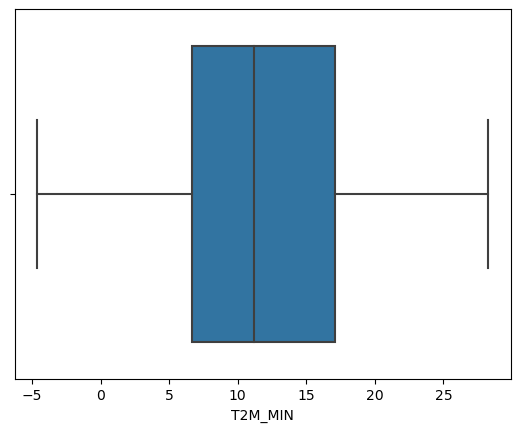

In [17]:
sns.boxplot(x=dataset["T2M_MIN"])

Ya no hay valores atípicos en la temperatura mínima

## 3- Representación + Descomposición y pequeño análisis gráfico de temperatura máxima

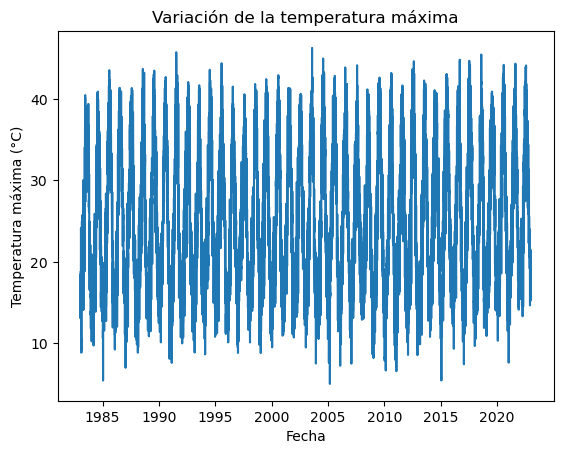

In [18]:
plt.plot(dataset['DATE'], dataset['T2M_MAX'])
plt.title('Variación de la temperatura máxima')
plt.xlabel('Fecha')
plt.ylabel('Temperatura máxima (°C)')
plt.show()

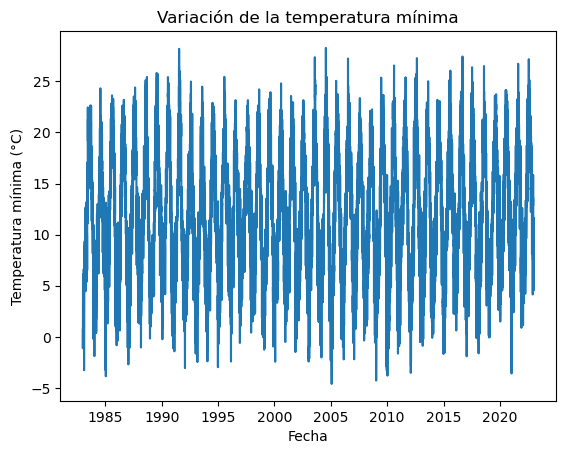

In [19]:
plt.plot(dataset['DATE'], dataset['T2M_MIN'])
plt.title('Variación de la temperatura mínima')
plt.xlabel('Fecha')
plt.ylabel('Temperatura mínima (°C)')
plt.show()

##### Descomponer la serie temperatura máxima en sus componentes de tendencia, estacionalidad y ruido

In [20]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(dataset['T2M_MAX'], model='additive', period=365)

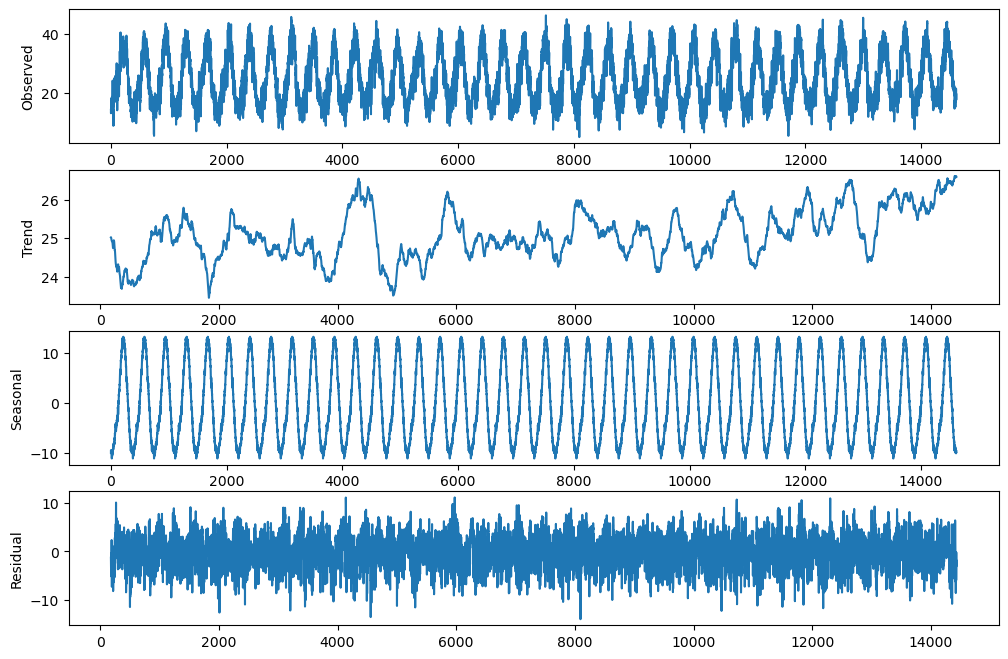

In [21]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')
decomposition.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')
plt.show()

Parece estacionaria, aunque realmente tiene una ligera tendencia creciente. Este tipo de comportamiento podría estar relacionado con cambios climáticos a largo plazo, como el calentamiento global.

##### Análisis de correlación

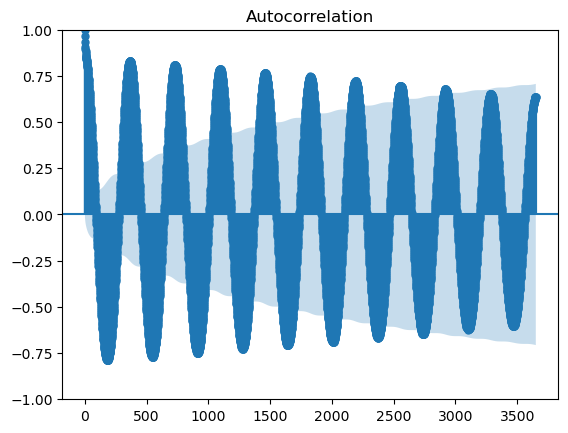

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dataset["T2M_MAX"].values, lags = 365*10)
plt.show()

Aunque la correlación sigue siendo periódica, la reducción de la amplitud sugiere que las variaciones interanuales en la temperatura máxima están disminuyendo gradualmente. 

# PREPROCESADO PARA LOS MODELOS

## 1- Separación de datos de entrenamiento y de test

Los datos de entrenamiento serán los tomados hasta el 31 de diciembre de 2019 y el resto, del 1 de enero de 2020 hasta el 1 de enero de 2023, serán datos de test.

In [23]:
dataset_training = dataset[dataset["YEAR"]< 2020]
dataset_training

DATE  YEAR  MO  DY  T2M_MAX  T2M_MIN
0      1983-01-01  1983   1   1    14.24     0.69
1      1983-01-02  1983   1   2    13.11    -1.12
2      1983-01-03  1983   1   3    13.94     0.01
3      1983-01-04  1983   1   4    16.24     0.91
4      1983-01-05  1983   1   5    17.07     3.06
...           ...   ...  ..  ..      ...      ...
13509  2019-12-27  2019  12  27    19.22     7.76
13510  2019-12-28  2019  12  28    19.85     7.19
13511  2019-12-29  2019  12  29    18.30     6.23
13512  2019-12-30  2019  12  30    16.56     4.56
13513  2019-12-31  2019  12  31    16.69     3.90

[13514 rows x 6 columns]

In [24]:
dataset_test = dataset[dataset["YEAR"] >= 2020]
dataset_test

DATE  YEAR  MO  DY  T2M_MAX  T2M_MIN
13514  2020-01-01  2020   1   1    16.14     4.26
13515  2020-01-02  2020   1   2    15.90     3.82
13516  2020-01-03  2020   1   3    15.13     4.83
13517  2020-01-04  2020   1   4    14.34     2.05
13518  2020-01-05  2020   1   5    16.06     5.30
...           ...   ...  ..  ..      ...      ...
14606  2022-12-28  2022  12  28    19.92     7.19
14607  2022-12-29  2022  12  29    17.58     7.56
14608  2022-12-30  2022  12  30    18.35     8.64
14609  2022-12-31  2022  12  31    17.90     4.55
14610  2023-01-01  2023   1   1    19.47     7.50

[1097 rows x 6 columns]

In [25]:
training_set = dataset_training.iloc[:, [2,4,5]].values # Mes, temp. máxima y temp. mínima de los datos de entrenamiento
real_values = dataset_test.iloc[:, [4]].values # Temperatura máxima de los datos de test
forecast_dates = dataset_test.iloc[:, 0].values # Fechas de los datos de test, que serán también las de las predicciones

## 2- Escalado de los datos

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(training_set)
training_set_scaled = scaler.transform(training_set)


## 3- Creación de la estructura de datos

In [27]:
X_train = [] 
y_train = [] # Ambas listas vacías servirán para almacenar datos de entrenamiento
n_future = 1   # Número de días en el futuro que queremos predecir
n_past = 90  # Número de días anteriores que usamos para predecir

El proximo bucle iterará a través de un bucle for desde `n_past` hasta la longitud del conjunto de datos de entrenamiento (`training_set_scaled`) menos `n_future` + 1. Esto permite seleccionar ventanas de datos de tamaño `n_past` para el entrenamiento.

Dentro del bucle, se agregan los datos de entrada y de salida correspondientes a las listas `X_train` e `y_train`, respectivamente.

- `X_train` contiene las secuencias de `n_past` días anteriores como características de entrada para el modelo.

- `y_train` contiene el valor correspondiente al día siguiente después de las `n_past` observaciones, que es el valor que se desea predecir.

Finalmente, se convierten las listas `X_train` e `y_train` en matrices numpy utilizando `np.array()`.

In [28]:
for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, :])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 1])

X_train, y_train = np.array(X_train), np.array(y_train)

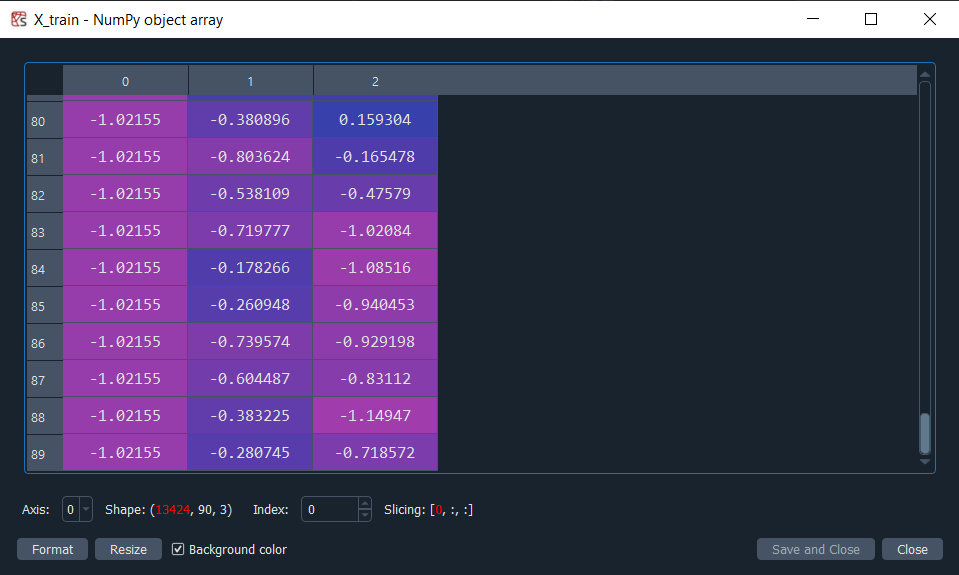

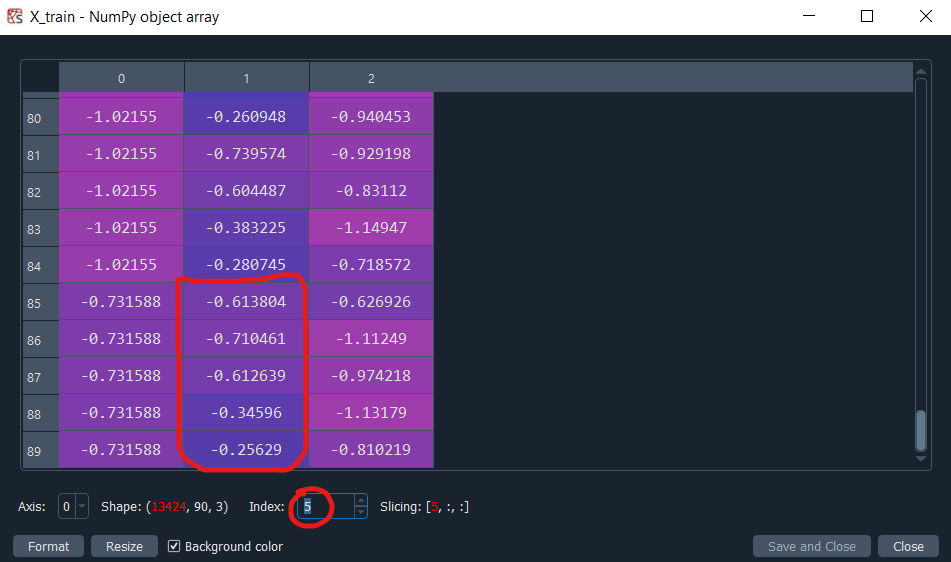

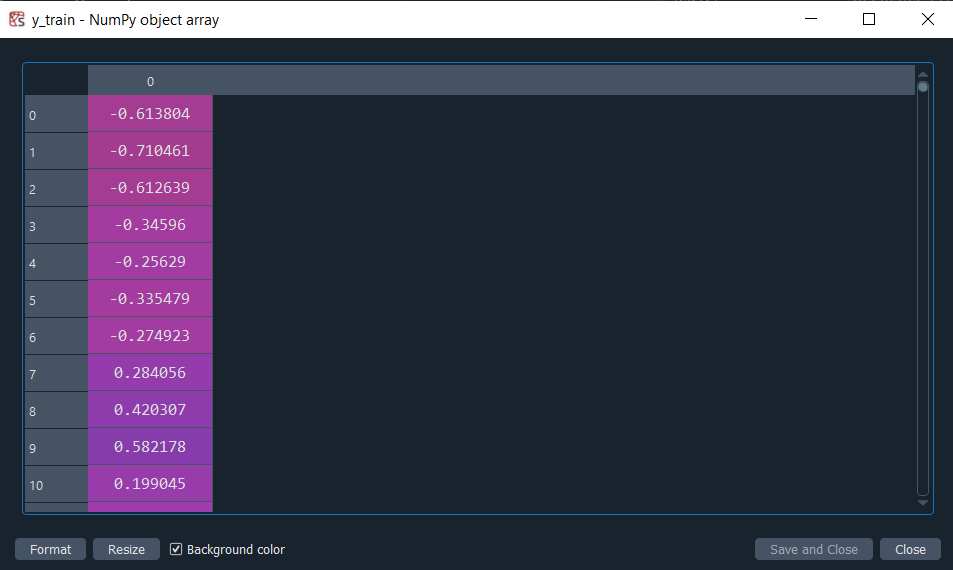

##### Repetimos ahora para los datos de test.
Primero hay que conseguir el set de datos correspondiente. Éste comienza `n_past` días antes del 1 de enero de 2020 (primer día de la predicción para los datos de test)

In [29]:
index = dataset_test.index[0]  # Índice del primer registro de 2020
test_set = dataset.iloc[(index-n_past):, [2,4,5]].values # Mes y temperaturas máxima y mínima comenzando n_past días atrás
test_set_scaled = scaler.transform(test_set)
X_test = []
y_test = []

for i in range(n_past, len(test_set_scaled) - n_future +1):
    X_test.append(test_set_scaled[i - n_past:i, :])
    y_test.append(test_set_scaled[i + n_future - 1:i + n_future, 1])
    
X_test, y_test = np.array(X_test), np.array(y_test)

# CREACIÓN Y ENTRENAMIENTO DE LOS MODELOS + GRÁFICOS

In [30]:
# Importamos las librerías necesarias para todos los modelos
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, MaxPooling1D
from keras.layers import GRU, LSTM
from keras.layers import Dense, Dropout

import sklearn.metrics as metrics # Métricas
from keras import backend as K # Para acceder a las funciones y operaciones del backend de Keras

import time # Para el monitorio y registro de los tiempos de ejecución
import psutil #Para el monitoreo y registro de los recursos del equipo

## 1- CNN + definición de funciones para el resto de modelos

Aquí se definen el `rmse` (root square mean error), `mape` (mean absolute percentage error) y `r2` (R-sqared, coefficient of determination) Esto es por comodidad en el código posterior, aunque Keras ya las implementa en `sklearn.metrics`

In [31]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [32]:
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100

In [33]:
# Definimos igualmente el R2 (R-squared)
def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / SS_tot
    return r2

#### El código del próximo prompt crea y compila un modelo de red neuronal convolucional (CNN) con la métrica mse (mean squared error) para la función de pérdida. A continuación, se explica qué hace cada parte del código:

1. Se crea un modelo de tipo secuencial (`Sequential`), que es una pila lineal de capas.

2. Se agregan capas al modelo:
   - Capa convolucional (`Conv1D`) con 64 filtros, un tamaño de kernel de 2 y función de activación 'relu'. La capa recibe una entrada con forma `(X_train.shape[1], X_train.shape[2])`, lo que significa que espera secuencias de datos con `X_train.shape[1]` pasos de tiempo y `X_train.shape[2]` características en cada paso de tiempo.
   - Capa de aplanamiento (`Flatten`) para convertir el tensor de salida de la capa convolucional en un vector unidimensional.
   - Capa de desactivación aleatoria (`Dropout`) con una tasa de desactivación del 20% para evitar el sobreajuste.
   - Capa densa (`Dense`) con 32 unidades y función de activación 'relu'.
   - Otra capa de desactivación aleatoria (`Dropout`) con una tasa de desactivación del 20%.
   - Capa densa (`Dense`) con un número de unidades igual a la dimensión de la variable de salida `y_train`.

3. Se compila el modelo utilizando el optimizador "adam" y la pérdida "mse" (error cuadrático medio) como función de pérdida. Además, se especifican métricas adicionales a evaluar durante el entrenamiento, incluyendo "rmse" (raíz cuadrada del error cuadrático medio), "mae" (error absoluto medio) y "r2" (coeficiente de determinación).

4. Se imprime un resumen del modelo utilizando el método `summary()` para mostrar la arquitectura y el número de parámetros entrenables.

In [34]:
model_CNN = Sequential()
model_CNN.add(Conv1D(64, kernel_size=2, activation='relu', 
                     input_shape=(X_train.shape[1], X_train.shape[2])))
model_CNN.add(Flatten())
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(32, activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(y_train.shape[1]))

model_CNN.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae', mape, r2])
model_CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 89, 64)            448       
                                                                 
 flatten (Flatten)           (None, 5696)              0         
                                                                 
 dropout (Dropout)           (None, 5696)              0         
                                                                 
 dense (Dense)               (None, 32)                182304    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 182,785
Trainable params: 182,785
Non-trai

#### Ajustar el modelo con los datos de entrenamiento y compror el training y validation loss

La función `train_model`, definida a continuación, tiene como objetivo secundario monitorizar los recursos del equipo y el tiempo transcurrido hasta completar el ajuste del modelo, sin embargo su objetivo principal es esto último, el ajuste del modelo. En cuanto  a esto, esta función realiza lo siguiente:
1. Itera sobre el número total de épocas definidas en `epochs_totales`.
2. Utiliza el método `fit` para entrenar el modelo durante una sola época. Los datos de entrenamiento y las etiquetas de entrenamiento se pasan como argumentos, así como los datos de validación y las etiquetas de validación para monitorear el rendimiento del modelo durante el entrenamiento.
3. Después de la época de entrenamiento, se utiliza el modelo para hacer predicciones en el conjunto de pruebas (`X_test`), y se escala inversamente las predicciones utilizando `scaler.inverse_transform`. Las predicciones escaladas se almacenan en la variable `forecast`.
4. Se calculan diferentes métricas de evaluación tanto en el conjunto de entrenamiento como en el conjunto de validación, y se almacenan en diferentes variables, como `losses`, `train_rmses`, `val_maes`, etc. Estas métricas se obtienen a partir del historial de entrenamiento (`history`) proporcionado por el método `fit`.
5. Se calculan métricas adicionales en el conjunto de validación sin escalar, utilizando funciones de la librería `metrics` de scikit-learn. Estas métricas incluyen el error cuadrático medio (MSE), la raíz cuadrada del error cuadrático medio (RMSE), el error absoluto medio (MAE), el error porcentual absoluto medio (MAPE) y el coeficiente de determinación (R2).
6. Se imprimen las métricas calculadas para cada época.
7. La función devuelve el historial de entrenamiento (`history`).

In [35]:
epochs_totales = 30

losses = np.zeros(epochs_totales)
train_rmses = np.zeros(epochs_totales)
train_maes = np.zeros(epochs_totales)
train_mapes = np.zeros(epochs_totales)
train_r2s = np.zeros(epochs_totales)

val_losses = np.zeros(epochs_totales)
val_rmses = np.zeros(epochs_totales)
val_maes = np.zeros(epochs_totales)
val_mapes = np.zeros(epochs_totales)
val_r2s = np.zeros(epochs_totales)

mses = np.zeros(epochs_totales)
rmses = np.zeros(epochs_totales)
maes = np.zeros(epochs_totales)
mapes = np.zeros(epochs_totales)
r2s = np.zeros(epochs_totales)


def train_model(model):
    cpu_before = psutil.cpu_percent() # Monitoreo del cpu
    memory_before = psutil.virtual_memory().percent # Monitoreo de la memoria
    start_time = time.time() # Registro del tiempo de inicio
    

    for epoch in range(epochs_totales):
        history = model.fit(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test),
                            verbose=1)  # Entrena por una época

        forecast_scaled = model.predict(X_test)
        forecast_scaled_copies = np.repeat(forecast_scaled, training_set.shape[1], axis=-1)
        forecast = scaler.inverse_transform(forecast_scaled_copies)[:, [1]]
        
        # Métricas en el conjunto de entrenamiento (escalado)
        losses[epoch] = history.history['loss'][0]
        train_rmses[epoch] = history.history['rmse'][0]
        train_maes[epoch] = history.history['mae'][0]
        train_mapes[epoch] = history.history['mape'][0]
        train_r2s[epoch] = history.history['r2'][0]
        
        # Métricas en el conjunto de validación (escalado)
        val_losses[epoch] = history.history['val_loss'][0]
        val_rmses[epoch] = history.history['val_rmse'][0]
        val_maes[epoch] = history.history['val_mae'][0]
        val_mapes[epoch] = history.history['val_mape'][0]
        val_r2s[epoch] = history.history['val_r2'][0]
        
        # Métricas en el conjunto de validación (sin escalar)
        mse = metrics.mean_squared_error(real_values, forecast)
        rmse2 = rmse(real_values, forecast).numpy()
        mae = metrics.mean_absolute_error(real_values, forecast)
        mape = metrics.mean_absolute_percentage_error(real_values, forecast)
        r2 = metrics.r2_score(real_values, forecast)
        
        mses[epoch] = mse
        rmses[epoch] = rmse2
        maes[epoch] = mae
        mapes[epoch] = mape
        r2s[epoch] = r2

        # Imprimimos las métricas
        print("Epoch {}/{}".format(epoch+1, epochs_totales))
        print("MSE:", mse)
        print("RMSE:", rmse2)
        print("MAE:", mae)
        print("MAPE:", mape)
        print("R2:", r2)
        print()

    
    end_time = time.time() # Registro del tiempo de finalización
    cpu_after = psutil.cpu_percent() #Cálculo cpu
    memory_after = psutil.virtual_memory().percent #Cálculo memoria
    elapsed_time = end_time - start_time # Cálculo del tiempo transcurrido

    print("Uso de CPU antes del entrenamiento:", cpu_before, "%")
    print("Uso de memoria antes del entrenamiento:", memory_before, "%")
    print("Uso de CPU después del entrenamiento:", cpu_after, "%")
    print("Uso de memoria después del entrenamiento:", memory_after, "%")
    print("Tiempo total de ejecución:", int(elapsed_time), "segundos")

    return history

In [36]:
history_CNN = train_model(model_CNN)

35/35 [==============================] - 0s 2ms/step
Epoch 1/30
MSE: 7.214051318369725
RMSE: 2.6858986053776723
MAE: 2.143079970819687
MAPE: 0.0930158775795302
R2: 0.8972638898628158

35/35 [==============================] - 0s 2ms/step
Epoch 2/30
MSE: 5.577910860295045
RMSE: 2.361760119126209
MAE: 1.8518267836522926
MAPE: 0.07925355034710287
R2: 0.9205643487703703

35/35 [==============================] - 0s 2ms/step
Epoch 3/30
MSE: 5.527059454670937
RMSE: 2.3509698965896897
MAE: 1.8202419745585214
MAPE: 0.07978853662117039
R2: 0.9212885293144601

35/35 [==============================] - 0s 2ms/step
Epoch 4/30
MSE: 4.998441202773039
RMSE: 2.2357193926727565
MAE: 1.7812982621101647
MAPE: 0.07506485468194063
R2: 0.9288166408499602

35/35 [==============================] - 0s 2ms/step
Epoch 5/30
MSE: 4.8725290974925155
RMSE: 2.207380596429287
MAE: 1.6947022683031472
MAPE: 0.07311670382262124
R2: 0.9306097691969634

35/35 [==============================] - 0s 3ms/step
Epoch 6/30
MSE: 5.62

In [37]:
def plot_metrics():
    """Grafica las curvas de pérdida de entrenamiento y validación (MSE), así como las métricas RMSE, MAE, MAPE y R2"""
    plt.figure(figsize=(10, 6))
    
    # Loss
    plt.subplot(3, 2, 1)
    plt.plot(range(1, epochs_totales+1), losses, label='Training loss(MSE)')
    plt.plot(range(1, epochs_totales+1), val_losses, label='Validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # RMSE
    plt.subplot(3, 2, 2)
    plt.plot(range(1, epochs_totales+1), train_rmses, label='Training RMSE')
    plt.plot(range(1, epochs_totales+1), val_rmses, label='Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()

    # MAE
    plt.subplot(3, 2, 3)
    plt.plot(range(1, epochs_totales+1), train_maes, label='Training MAE')
    plt.plot(range(1, epochs_totales+1), val_maes, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()

    # MAPE
    plt.subplot(3, 2, 4)
    plt.plot(range(1, epochs_totales+1), train_mapes, label='Training MAPE')
    plt.plot(range(1, epochs_totales+1), val_mapes, label='Validation MAPE')
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.legend()    
    
    # R2
    plt.subplot(3, 2, 5)
    plt.plot(range(1, epochs_totales+1), train_r2s, label='Training R2')
    plt.plot(range(1, epochs_totales+1), val_r2s, label='Validation R2')
    plt.xlabel('Epochs')
    plt.ylabel('R2')
    plt.legend()

    plt.tight_layout()
    plt.show()

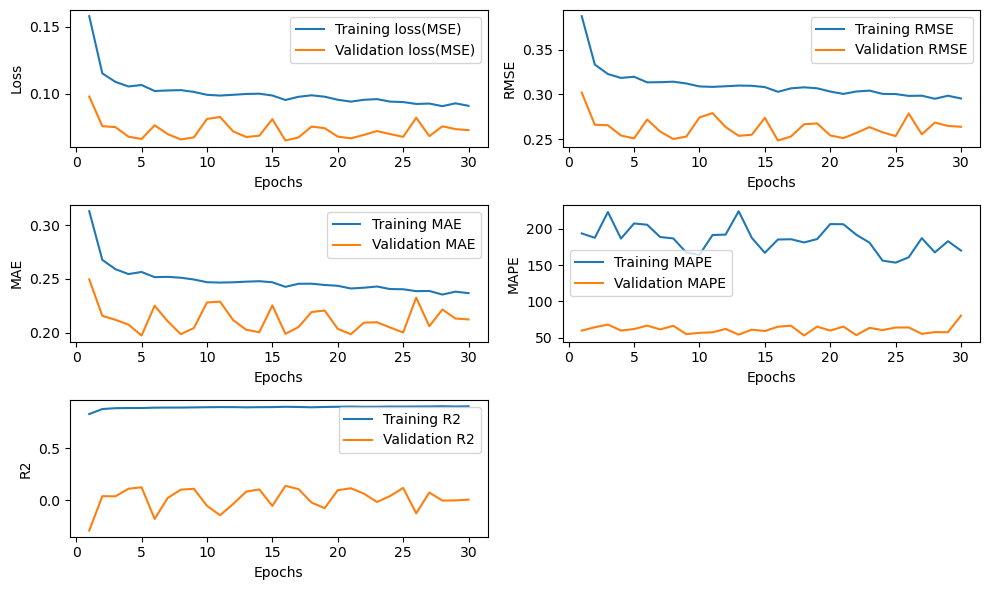

In [38]:
plot_metrics()

In [39]:
def plot_real_metrics():
    """Grafica las curvas de pérdida de validación de las métricas MSE, RMSE, MAE, MAPE y R2 con los datos reales(sin escalar) """
    plt.figure(figsize=(10, 6))

    # Gráfico de pérdida
    plt.subplot(3, 2, 1)
    plt.plot(range(1, epochs_totales+1), mses)
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSE over epochs')

    # Gráfico de RMSE
    plt.subplot(3, 2, 2)
    plt.plot(range(1, epochs_totales+1), rmses)
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('RMSE over epochs')

    # Gráfico de MAE
    plt.subplot(3, 2, 3)
    plt.plot(range(1, epochs_totales+1), maes)
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('MAE over epochs')

    # Gráfico de MAPE
    plt.subplot(3, 2, 4)
    plt.plot(range(1, epochs_totales+1), mapes)
    plt.xlabel('Epochs')
    plt.ylabel('MAPE')
    plt.title('MAPE over epochs')

    # Gráfico de R2
    plt.subplot(3, 2, 5)
    plt.plot(range(1, epochs_totales+1), r2s)
    plt.xlabel('Epochs')
    plt.ylabel('R2')
    plt.title('R2 over epochs')

    plt.tight_layout()
    plt.show()


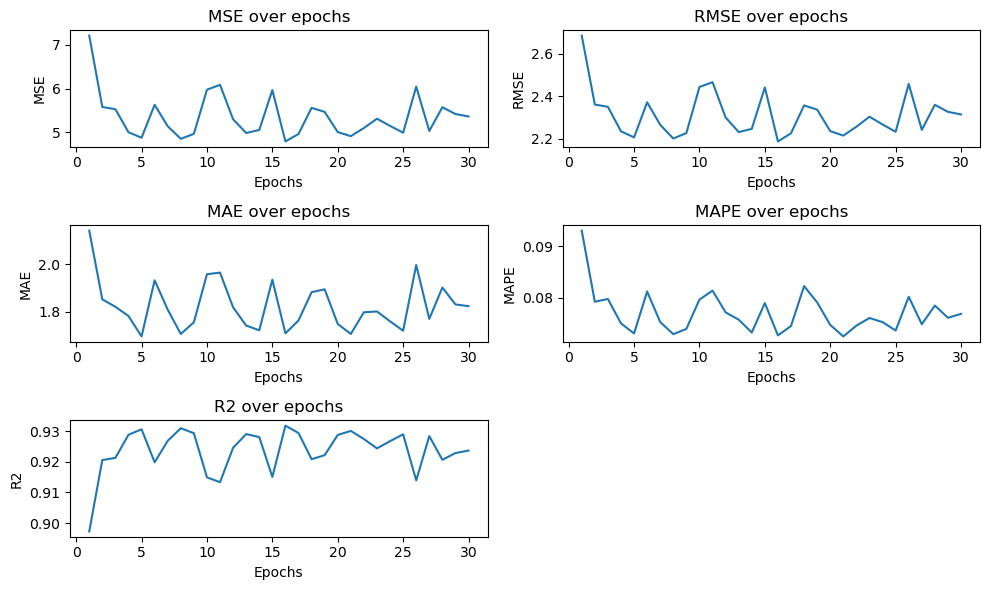

In [40]:
plot_real_metrics()

#### Calcular el vector de predicciones

In [41]:
def generate_forecast(model):
    """Calcula el vector de predicciones de X_test con respecto al modelo  model, dado como dato de entrada"""
    forecast_scaled = model.predict(X_test)
    forecast_scaled_copies = np.repeat(forecast_scaled, training_set.shape[1], axis=-1)
    forecast = scaler.inverse_transform(forecast_scaled_copies)[:, [1]]
    
    return forecast

In [42]:
forecast_CNN = generate_forecast(model_CNN)

35/35 [==============================] - 0s 3ms/step


#### Representación de resultados

In [43]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [44]:
def plot_scatter_with_line(forecast):
    """
    Genera un gráfico de dispersión con una línea de referencia ft = yt.
    Los valores pronosticados se comparan con los valores reales.
    """
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Graficar los puntos
    ax.scatter(real_values, forecast, color='blue', label='Puntos')

    # Graficar la recta ft = yt
    ax.plot(real_values, real_values, color='red', label='ft = yt')

    # Etiquetas de los ejes y título
    ax.set_xlabel('yt')
    ax.set_ylabel('ft')
    ax.set_title('(yt, ft)')

    # Mostrar la leyenda
    ax.legend()

    # Mostrar la figura
    plt.show()

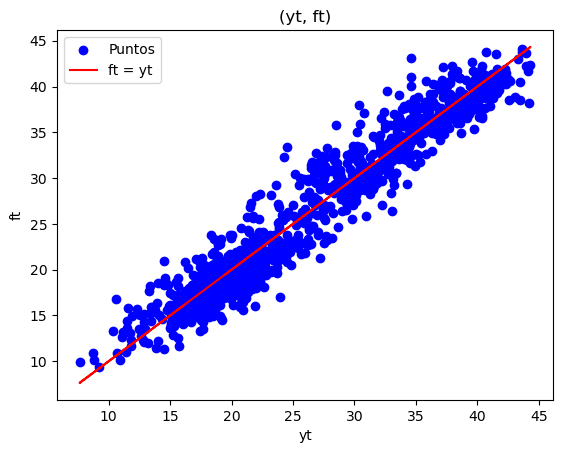

In [45]:
plot_scatter_with_line(forecast_CNN)

In [46]:
def generate_plot(forecast):
    # Crear la figura con subtramas
    fig = make_subplots(rows=1, cols=1)

    # Agregar la traza para los datos de forecast y forecast_dates
    fig.add_trace(go.Scatter(x=forecast_dates, y=forecast.flatten(), mode='lines', name='Forecast'))

    # Agregar la traza para los datos de real_values
    fig.add_trace(go.Scatter(x=forecast_dates, y=real_values.flatten(), mode='lines', name='Real Values'))

    # Personalizar el diseño de la gráfica
    fig.update_layout(title='Forecast vs Real Values', xaxis_title='Fecha', yaxis_title='Valor')

    # Mostrar la gráfica
    fig.show()

In [47]:
generate_plot(forecast_CNN)

## 2.1- LSTM

El modelo `model_LSTM` definido en el código utiliza una red neuronal recurrente LSTM (Long Short-Term Memory) para el aprendizaje y la predicción. A continuación se explica cada línea de código:

1. Se crea un objeto de modelo secuencial llamado `model_LSTM`.

2. Se agrega una capa LSTM al modelo con 32 unidades y activación "tanh". La capa recibe una entrada con forma `(X_train.shape[1], X_train.shape[2])`, que representa el número de pasos de tiempo y el número de características en los datos de entrada. Al establecer `return_sequences=False`, la capa LSTM devuelve solo la última salida de la secuencia en lugar de una secuencia completa.

3. Se agrega una capa de dropout con una tasa de 0.1. El dropout es una técnica de regularización que ayuda a prevenir el sobreajuste al apagar aleatoriamente algunas neuronas durante el entrenamiento.

4. Se agrega una capa densa (fully connected) al modelo con tantas unidades como características de salida (`y_train.shape[1]`). Esta capa genera las predicciones finales. No se especifica ninguna función de activación, lo que significa que se utilizará una activación lineal por defecto.

5. Se compila el modelo utilizando el optimizador "adam" y la función de pérdida "mse" (error cuadrático medio). El optimizador "adam" es un algoritmo de optimización popular y eficiente. Además, se especifican métricas adicionales a evaluar durante el entrenamiento, incluyendo rmse (raíz cuadrada del error cuadrático medio), mae (error absoluto medio), mape (porcentaje de error medio absoluto) y r2 (coeficiente de determinación).

6. Se muestra un resumen del modelo, que proporciona una descripción de cada capa, su forma de salida y el número de parámetros entrenables.

In [48]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences = False))
model_LSTM.add(Dropout(0.1))
model_LSTM.add(Dense(y_train.shape[1]))

model_LSTM.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae', mape, r2])
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_LSTM = train_model(model_LSTM)

35/35 [==============================] - 1s 8ms/step
Epoch 1/30
MSE: 6.239375222513588
RMSE: 2.4978741406471197
MAE: 2.003749705917094
MAPE: 0.0840319932272924
R2: 0.9111443609480403

35/35 [==============================] - 0s 9ms/step
Epoch 2/30
MSE: 4.671941730402306
RMSE: 2.16146749464393
MAE: 1.6943696560159855
MAPE: 0.07133161554569632
R2: 0.9334663562834778

35/35 [==============================] - 0s 8ms/step
Epoch 3/30
MSE: 4.885655334835006
RMSE: 2.2103518576993584
MAE: 1.771204351287814
MAPE: 0.07287599493533142
R2: 0.930422836985673

35/35 [==============================] - 0s 8ms/step
Epoch 4/30
MSE: 4.885776142319573
RMSE: 2.21037918518963
MAE: 1.771579402203764
MAPE: 0.0736822632808523
R2: 0.9304211165527994

35/35 [==============================] - 0s 8ms/step
Epoch 5/30
MSE: 4.540892118689798
RMSE: 2.1309369110064704
MAE: 1.635518825986544
MAPE: 0.06934516239577371
R2: 0.9353326484330843

35/35 [==============================] - 0s 8ms/step
Epoch 6/30
MSE: 4.6083031972

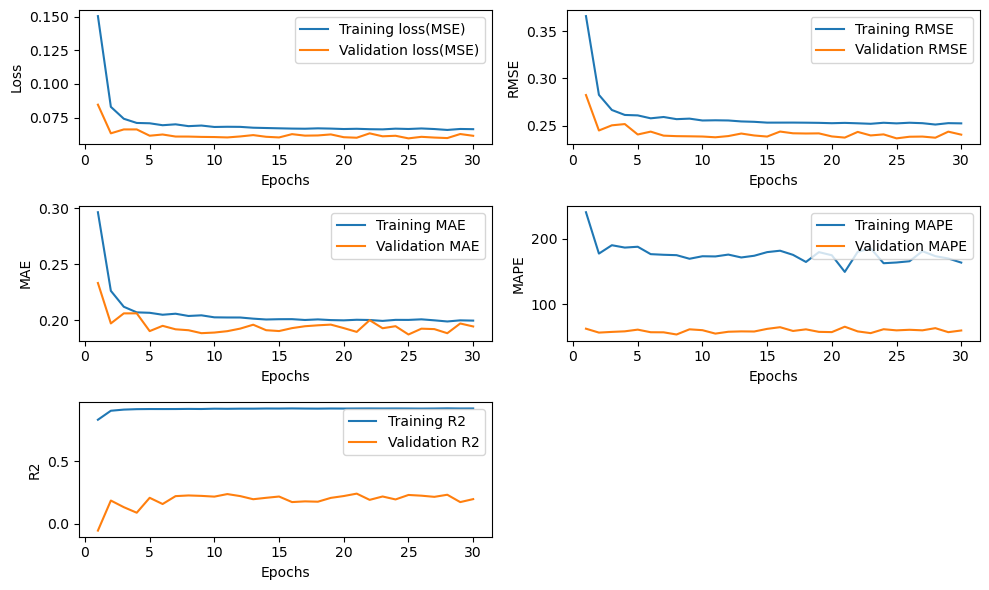

In [50]:
plot_metrics()

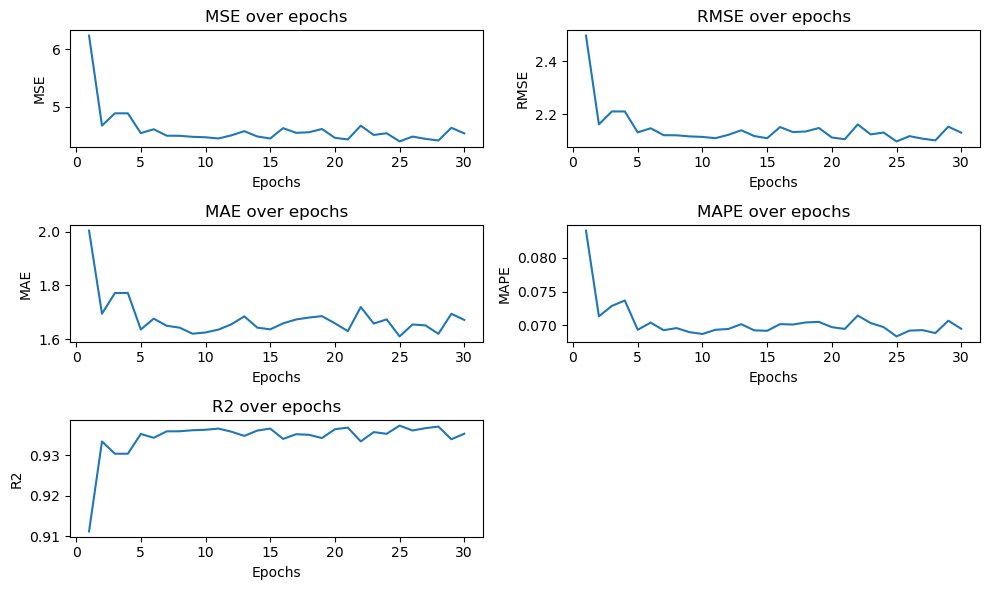

In [51]:
plot_real_metrics()

In [52]:
forecast_LSTM = generate_forecast(model_LSTM)

35/35 [==============================] - 0s 8ms/step


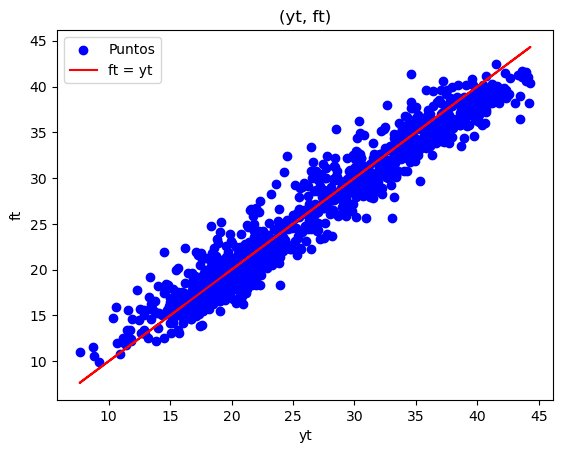

In [53]:
plot_scatter_with_line(forecast_LSTM)

In [54]:
generate_plot(forecast_LSTM)

## 2.2- LSMT_large

El código del model_LSTM_large, proporcionado a continuación, define y compila un modelo de red neuronal recurrente LSTM (Long Short-Term Memory). Aquí está una explicación paso a paso de lo que hace cada línea de código:

1. Se crea un objeto de modelo secuencial llamado `model_LSTM_large`.

2. Se agrega una capa LSTM al modelo con 64 unidades y activación "tanh". La capa recibe una entrada con forma `(X_train.shape[1], X_train.shape[2])`. Además, se establece `return_sequences=True` para que la capa LSTM devuelva secuencias de salidas en lugar de una única salida.

3. Se agrega una capa de dropout con una tasa de 0.2 para regularizar la red y evitar el sobreajuste.

4. Se agrega otra capa LSTM al modelo con 64 unidades y activación "tanh". También se establece `return_sequences=True` para mantener la salida como una secuencia.

5. Se agrega otra capa de dropout con una tasa de 0.2.

6. Se agrega una tercera capa LSTM al modelo con 32 unidades y activación "tanh". Esta vez, `return_sequences` se establece en `False` para que la capa LSTM devuelva solo la última salida de la secuencia.

7. Se agrega otra capa de dropout con una tasa de 0.2.

8. Se agrega una capa densa (fully connected) al modelo con tantas unidades como características de salida (`y_train.shape[1]`). Esta capa genera las predicciones finales.

9. Se compila el modelo utilizando el optimizador "adam" y la pérdida "mse" (error cuadrático medio) como función de pérdida. Además, se especifican métricas adicionales a evaluar durante el entrenamiento, incluyendo "rmse" (raíz cuadrada del error cuadrático medio), "mae" (error absoluto medio) y "r2" (coeficiente de determinación).

10. Se muestra un resumen del modelo, que proporciona una descripción de cada capa, su forma de salida y el número de parámetros entrenables.

In [55]:
model_LSTM_large = Sequential()
model_LSTM_large.add(LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences = True))
model_LSTM_large.add(Dropout(0.2))
model_LSTM_large.add(LSTM(64, activation = 'tanh', return_sequences = True))
model_LSTM_large.add(Dropout(0.2))
model_LSTM_large.add(LSTM(32, activation = 'tanh', return_sequences = False))
model_LSTM_large.add(Dropout(0.2))
model_LSTM_large.add(Dense(y_train.shape[1]))

model_LSTM_large.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae', mape, r2])
model_LSTM_large.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 90, 64)            17408     
                                                                 
 dropout_3 (Dropout)         (None, 90, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 90, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [56]:
history_LSTM_large = train_model(model_LSTM_large)

35/35 [==============================] - 2s 24ms/step
Epoch 1/30
MSE: 6.97692635288204
RMSE: 2.6413872023771976
MAE: 2.150653751759281
MAPE: 0.08947865694520574
R2: 0.90064081296684

35/35 [==============================] - 1s 24ms/step
Epoch 2/30
MSE: 5.0229649730844015
RMSE: 2.241197218694598
MAE: 1.7542192344004823
MAPE: 0.07426233096766584
R2: 0.9284673950993413

35/35 [==============================] - 1s 27ms/step
Epoch 3/30
MSE: 4.6321467144198
RMSE: 2.1522422527261655
MAE: 1.6462663311467132
MAPE: 0.07068726596970686
R2: 0.934033081548445

35/35 [==============================] - 2s 46ms/step
Epoch 4/30
MSE: 4.805924605504366
RMSE: 2.1922419130890565
MAE: 1.6502467289509941
MAPE: 0.07048531698150433
R2: 0.9315582912024974

35/35 [==============================] - 1s 25ms/step
Epoch 5/30
MSE: 4.63954412601714
RMSE: 2.153960103162809
MAE: 1.6336009794598618
MAPE: 0.07078992946694408
R2: 0.9339277341841062

35/35 [==============================] - 1s 24ms/step
Epoch 6/30
MSE: 4.64

35/35 [==============================] - 1s 25ms/step
Epoch 21/30
MSE: 4.739725453165566
RMSE: 2.1770910530259338
MAE: 1.7424010556898228
MAPE: 0.07233497357987957
R2: 0.9325010407208366

35/35 [==============================] - 1s 24ms/step
Epoch 22/30
MSE: 4.474634743180042
RMSE: 2.1153332463656978
MAE: 1.6267132300600313
MAPE: 0.06938982096401859
R2: 0.9362762271141005

35/35 [==============================] - 1s 24ms/step
Epoch 23/30
MSE: 4.507752607134053
RMSE: 2.123146864240449
MAE: 1.6738613618974156
MAPE: 0.07050034986512814
R2: 0.9358045919165489

35/35 [==============================] - 1s 24ms/step
Epoch 24/30
MSE: 5.019752556275064
RMSE: 2.2404804297906877
MAE: 1.8050411812739686
MAPE: 0.07463203281259313
R2: 0.9285131434857286

35/35 [==============================] - 1s 24ms/step
Epoch 25/30
MSE: 4.640313401080558
RMSE: 2.1541386680250083
MAE: 1.7013366262110776
MAPE: 0.0715633920119738
R2: 0.9339167788520532

35/35 [==============================] - 1s 25ms/step
Epoch 26

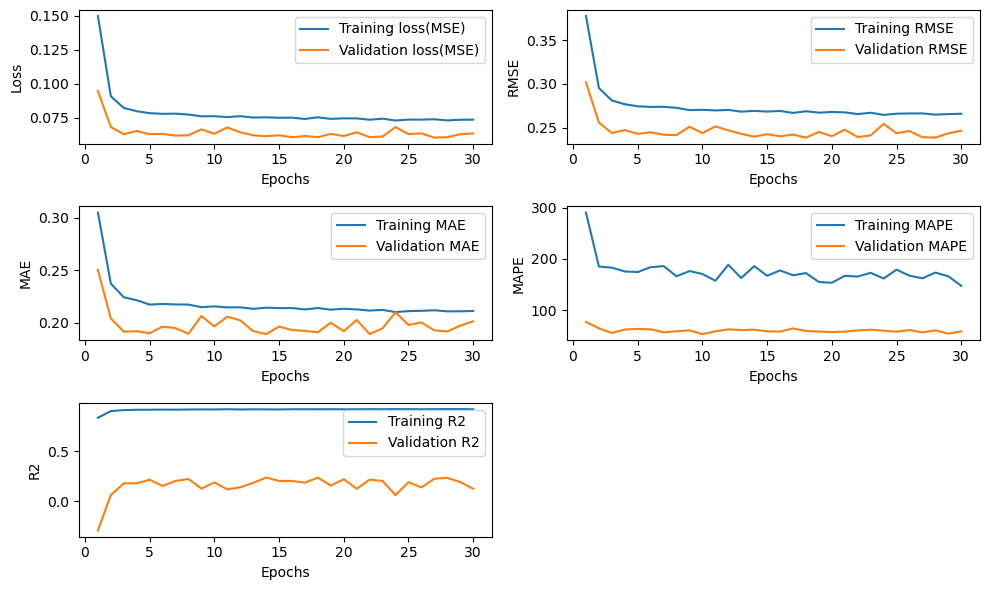

In [57]:
plot_metrics()

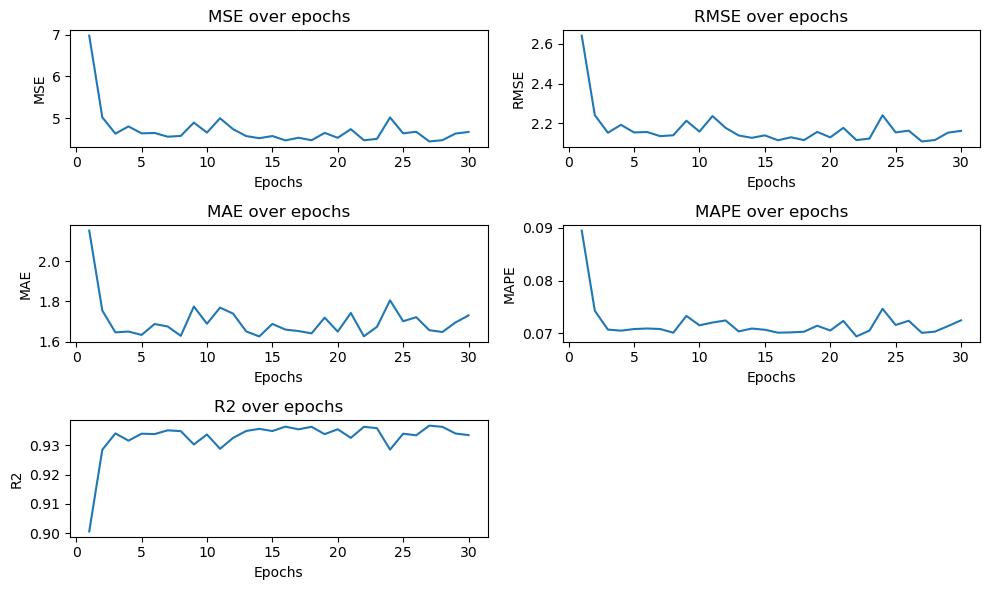

In [58]:
plot_real_metrics()

In [59]:
forecast_LSTM_large = generate_forecast(model_LSTM_large)

35/35 [==============================] - 1s 23ms/step


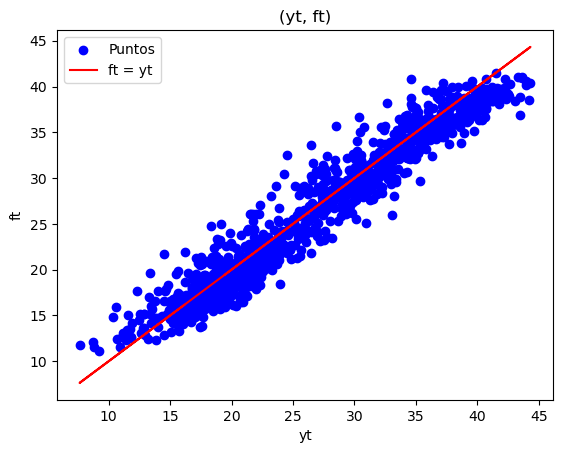

In [60]:
plot_scatter_with_line(forecast_LSTM_large)

In [61]:
generate_plot(forecast_LSTM_large)

## 3.1- GRU

El código del model_GRU, proporcionado a continuación, define y compila un modelo de red neuronal recurrente GRU (Gated Recurrent Unit). A continuación, se explica paso a paso lo que hace cada línea de código:

1. Se crea un objeto de modelo secuencial llamado `model_GRU`.

2. Se agrega una capa GRU al modelo con 32 unidades y activación "tanh". La capa recibe una entrada con forma `(X_train.shape[1], X_train.shape[2])`. Además, se establece `return_sequences=False` para que la capa GRU devuelva solo la última salida de la secuencia en lugar de secuencias completas.

3. Se agrega una capa de dropout con una tasa de 0.1 para regularizar la red y evitar el sobreajuste.

4. Se agrega una capa densa (fully connected) al modelo con tantas unidades como características de salida (`y_train.shape[1]`). Esta capa genera las predicciones finales.

5. Se compila el modelo utilizando el optimizador "adam" y la pérdida "mse" (error cuadrático medio) como función de pérdida. Además, se especifican métricas adicionales a evaluar durante el entrenamiento, incluyendo "rmse" (raíz cuadrada del error cuadrático medio), "mae" (error absoluto medio), "mape" (porcentaje de error medio absoluto) y "r2" (coeficiente de determinación).

6. Se muestra un resumen del modelo, que proporciona una descripción de cada capa, su forma de salida y el número de parámetros entrenables.


In [62]:
model_GRU = Sequential()
model_GRU.add(GRU(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences = False))
model_GRU.add(Dropout(0.1))
model_GRU.add(Dense(y_train.shape[1]))

model_GRU.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae', mape, r2])
model_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3552      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


In [63]:
history_GRU = train_model(model_GRU)

35/35 [==============================] - 1s 6ms/step
Epoch 1/30
MSE: 4.74089159621937
RMSE: 2.1773588579330165
MAE: 1.7021318238848648
MAPE: 0.07137285312845644
R2: 0.9324844335474296

35/35 [==============================] - 0s 7ms/step
Epoch 2/30
MSE: 4.651478591728048
RMSE: 2.1567286782829327
MAE: 1.6367653014079593
MAPE: 0.06974699610929953
R2: 0.93375777412566

35/35 [==============================] - 0s 8ms/step
Epoch 3/30
MSE: 4.51636391774999
RMSE: 2.125173855888028
MAE: 1.638177254849819
MAPE: 0.06925510150365345
R2: 0.9356819572807774

35/35 [==============================] - 0s 7ms/step
Epoch 4/30
MSE: 4.5338805262795345
RMSE: 2.1292910853801863
MAE: 1.653079441456547
MAPE: 0.06926572423788564
R2: 0.9354325013033103

35/35 [==============================] - 0s 7ms/step
Epoch 5/30
MSE: 4.591579384649615
RMSE: 2.142797093672104
MAE: 1.687936500020753
MAPE: 0.07014794019138376
R2: 0.9346108054202766

35/35 [==============================] - 0s 10ms/step
Epoch 6/30
MSE: 4.537303

35/35 [==============================] - 0s 7ms/step
Epoch 21/30
MSE: 4.355736850942768
RMSE: 2.0870402130631716
MAE: 1.6039618817436334
MAPE: 0.06859361215953844
R2: 0.9379694652701507

35/35 [==============================] - 0s 8ms/step
Epoch 22/30
MSE: 4.547734351250865
RMSE: 2.132541758383846
MAE: 1.693264830770988
MAPE: 0.07043981466771315
R2: 0.9352352074353764

35/35 [==============================] - 0s 7ms/step
Epoch 23/30
MSE: 4.530450074792461
RMSE: 2.128485394545253
MAE: 1.6709076850633788
MAPE: 0.06970229042818435
R2: 0.9354813547458828

35/35 [==============================] - 0s 7ms/step
Epoch 24/30
MSE: 4.391639026663185
RMSE: 2.0956237798477053
MAE: 1.6198129757556898
MAPE: 0.06864782945171938
R2: 0.9374581783779179

35/35 [==============================] - 0s 8ms/step
Epoch 25/30
MSE: 4.646710381190596
RMSE: 2.155622968236931
MAE: 1.6939966704960614
MAPE: 0.07153294501360172
R2: 0.9338256787442043

35/35 [==============================] - 0s 7ms/step
Epoch 26/30
MSE:

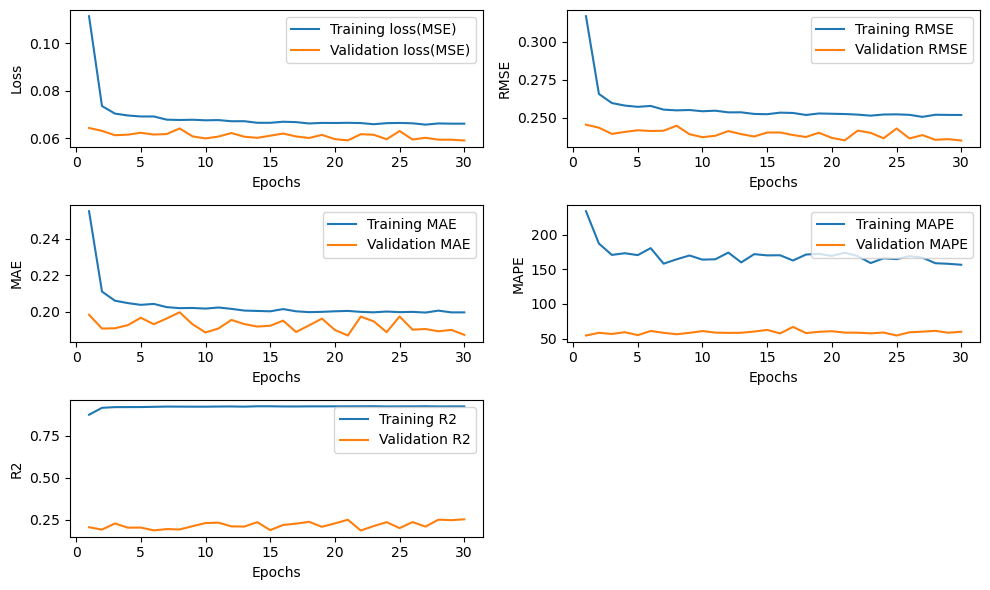

In [64]:
plot_metrics()

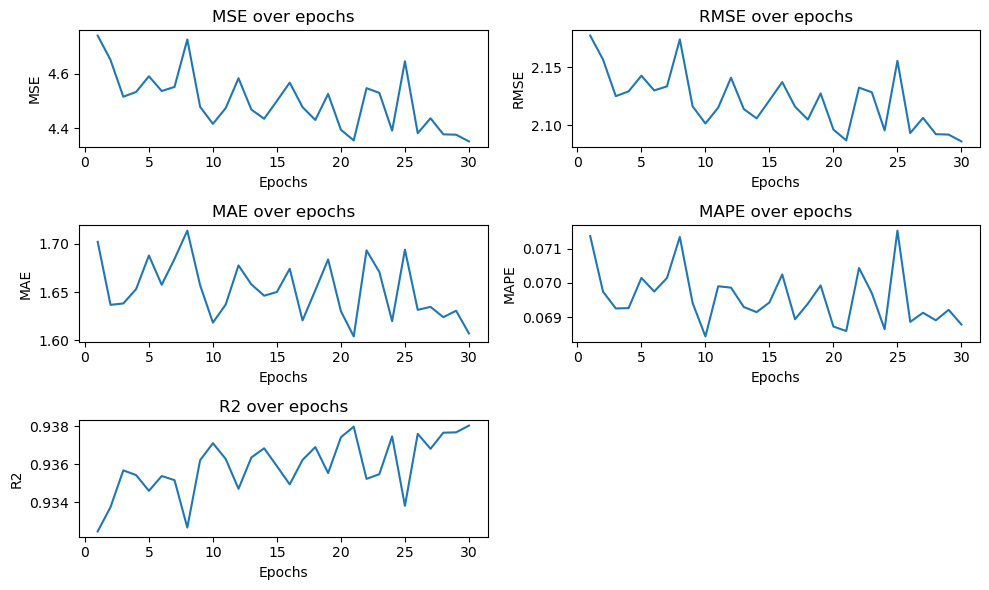

In [65]:
plot_real_metrics()

In [66]:
forecast_GRU = generate_forecast(model_GRU)

35/35 [==============================] - 0s 8ms/step


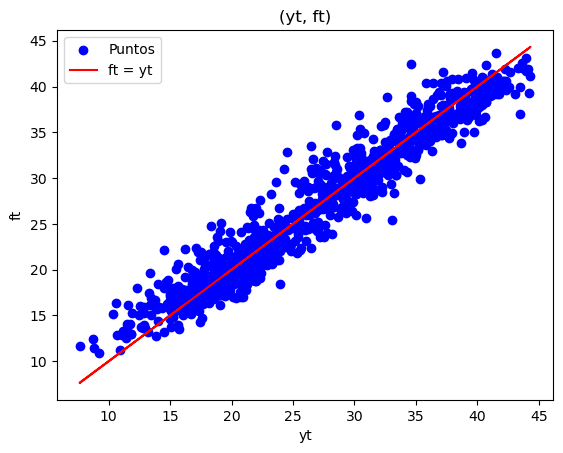

In [67]:
plot_scatter_with_line(forecast_GRU)

In [68]:
generate_plot(forecast_GRU)

## 3.2- GRU_large

El código del model_GRU_large, escrito en el siguiente prompt, define y compila un modelo de red neuronal recurrente GRU (Gated Recurrent Unit). Aquí está una explicación paso a paso de lo que hace cada línea de código:

1. Se crea un objeto de modelo secuencial llamado `model_GRU_large`.

2. Se agrega una capa GRU al modelo con 64 unidades y activación "tanh". La capa recibe una entrada con forma `(X_train.shape[1], X_train.shape[2])`. Además, se establece `return_sequences=True` para que la capa GRU devuelva secuencias de salidas en lugar de una única salida.

3. Se agrega una capa de dropout con una tasa de 0.2 para regularizar la red y evitar el sobreajuste.

4. Se agrega otra capa GRU al modelo con 64 unidades y activación "tanh". También se establece `return_sequences=True` para mantener la salida como una secuencia.

5. Se agrega otra capa de dropout con una tasa de 0.2.

6. Se agrega una cuarta capa GRU al modelo con 32 unidades y activación "tanh". Esta vez, `return_sequences` se establece en `False` para que la capa GRU devuelva solo la última salida de la secuencia.

7. Se agrega otra capa de dropout con una tasa de 0.2.

8. Se agrega una capa densa (fully connected) al modelo con tantas unidades como características de salida (`y_train.shape[1]`). Esta capa genera las predicciones finales.

9. Se compila el modelo utilizando el optimizador "adam" y la pérdida "mse" (error cuadrático medio) como función de pérdida. Además, se especifican métricas adicionales a evaluar durante el entrenamiento, incluyendo "rmse" (raíz cuadrada del error cuadrático medio), "mae" (error absoluto medio) y "r2" (coeficiente de determinación).

10. Se muestra un resumen del modelo, que proporciona una descripción de cada capa, su forma de salida y el número de parámetros entrenables.

In [69]:
model_GRU_large = Sequential()
model_GRU_large.add(GRU(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), 
               return_sequences = True))
model_GRU_large.add(Dropout(0.2))
model_GRU_large.add(GRU(64, activation = 'tanh', return_sequences = True))
model_GRU_large.add(Dropout(0.2))
model_GRU_large.add(GRU(32, activation = 'tanh', return_sequences = False))
model_GRU_large.add(Dropout(0.2))
model_GRU_large.add(Dense(y_train.shape[1]))

model_GRU_large.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mae', mape, r2])
model_GRU_large.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 90, 64)            13248     
                                                                 
 dropout_7 (Dropout)         (None, 90, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 90, 64)            24960     
                                                                 
 dropout_8 (Dropout)         (None, 90, 64)            0         
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [70]:
history_GRU_large = train_model(model_GRU_large)

35/35 [==============================] - 2s 22ms/step
Epoch 1/30
MSE: 4.609721662279831
RMSE: 2.147026236979844
MAE: 1.6448644278499356
MAPE: 0.06940371868498818
R2: 0.9343524392193029

35/35 [==============================] - 1s 23ms/step
Epoch 2/30
MSE: 4.7837876318110535
RMSE: 2.187187150614015
MAE: 1.7235917502571043
MAPE: 0.07138932518681307
R2: 0.931873546316038

35/35 [==============================] - 1s 23ms/step
Epoch 3/30
MSE: 5.162389215427718
RMSE: 2.272089174180388
MAE: 1.81013436507831
MAPE: 0.074869603361206
R2: 0.9264818389000525

35/35 [==============================] - 1s 23ms/step
Epoch 4/30
MSE: 4.655413558646626
RMSE: 2.157640739012551
MAE: 1.6649955496357696
MAPE: 0.07098812038883338
R2: 0.9337017358225079

35/35 [==============================] - 1s 22ms/step
Epoch 5/30
MSE: 4.667654756718939
RMSE: 2.1604755857724793
MAE: 1.7052837852053786
MAPE: 0.07153806287535927
R2: 0.9335274075542621

35/35 [==============================] - 1s 23ms/step
Epoch 6/30
MSE: 4.8

35/35 [==============================] - 2s 51ms/step
Epoch 21/30
MSE: 4.555537373425182
RMSE: 2.1343704864491504
MAE: 1.6885106033353015
MAPE: 0.07080827600102166
R2: 0.9351240837255321

35/35 [==============================] - 2s 51ms/step
Epoch 22/30
MSE: 4.489905554476907
RMSE: 2.118939724125466
MAE: 1.6299660711018953
MAPE: 0.06950663659037393
R2: 0.9360587537857248

35/35 [==============================] - 1s 21ms/step
Epoch 23/30
MSE: 4.874935274321794
RMSE: 2.207925559053519
MAE: 1.7698642913275888
MAPE: 0.07479760163511075
R2: 0.9305755025641335

35/35 [==============================] - 2s 45ms/step
Epoch 24/30
MSE: 4.577965942673615
RMSE: 2.1396181768422173
MAE: 1.6780403855635888
MAPE: 0.07097784710142695
R2: 0.93480467596714

35/35 [==============================] - 1s 41ms/step
Epoch 25/30
MSE: 4.5705756988860315
RMSE: 2.1378904786929636
MAE: 1.6256404992853823
MAPE: 0.0698493459254022
R2: 0.9349099212538998

35/35 [==============================] - 1s 40ms/step
Epoch 26/3

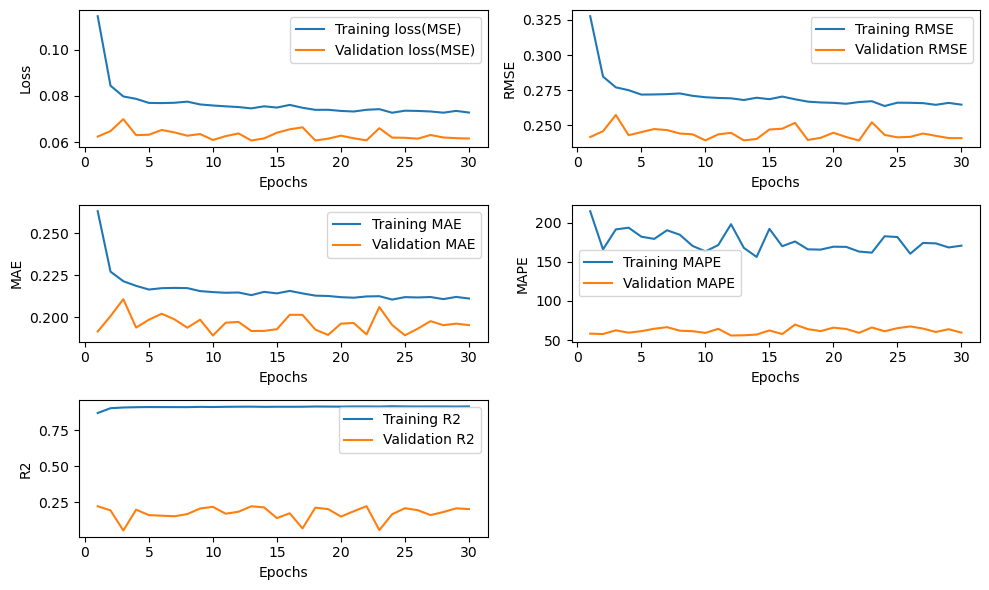

In [71]:
plot_metrics()

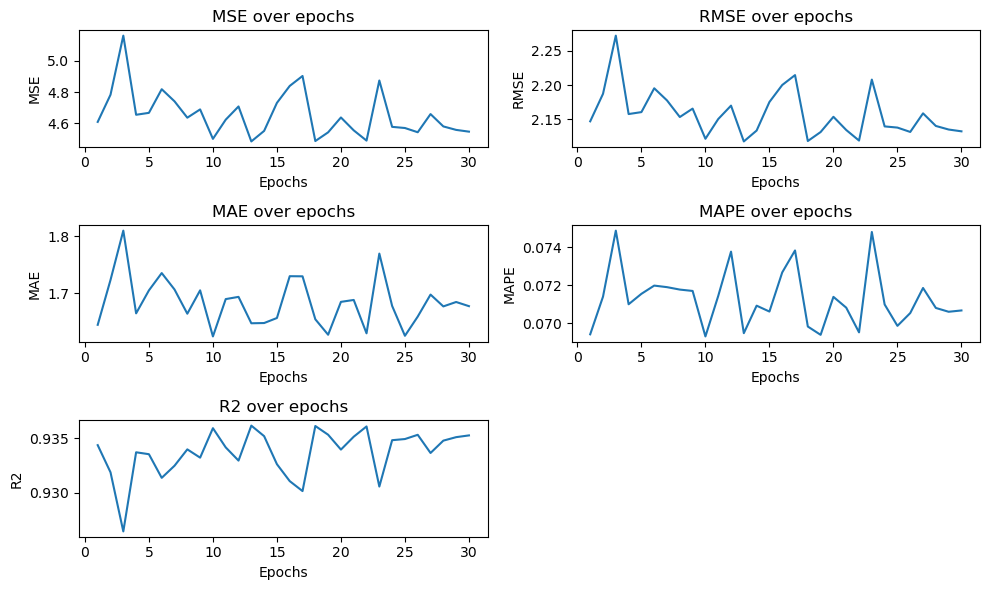

In [72]:
plot_real_metrics()

In [73]:
forecast_GRU_large = generate_forecast(model_GRU_large)

35/35 [==============================] - 1s 24ms/step


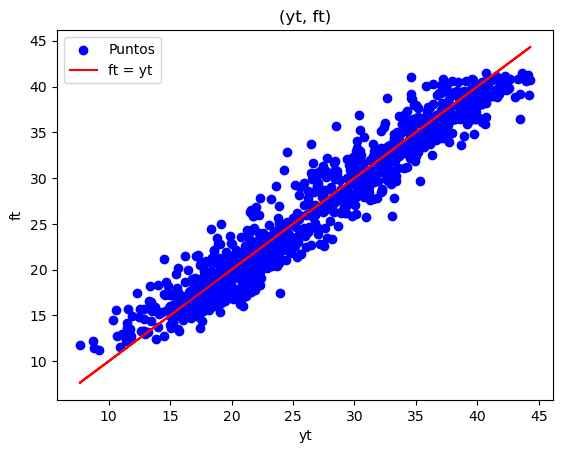

In [74]:
plot_scatter_with_line(forecast_GRU_large)

In [75]:
generate_plot(forecast_GRU_large)

## 4- NAIVE

El último modelo será un "modelo ingenuo" que se basa en la predicción de la temperatura utilizando el valor del día anterior. Este modelo se utilizará como punto de referencia para compararlo con los demás modelos.

In [76]:
index = dataset_test.index[0]  # Índice del primer registro de 2020
X_train_naive = dataset.iloc[(index-1):, [4]].values # Temperatura máxima desde el 31 de diciembre de 2019

In [77]:
forecast_naive = X_train_naive[:-1] # Simplemente se quita el último valor

#### Cálculo de las métricas de los modelos (validación sin escalar)

In [78]:
def calculate_metrics(forecast):    
    MSE = metrics.mean_squared_error(real_values, forecast)
    RMSE = rmse(real_values, forecast).numpy()
    MAE = metrics.mean_absolute_error(real_values, forecast)
    MAPE = metrics.mean_absolute_percentage_error(real_values, forecast)
    R2 = metrics.r2_score(real_values, forecast)
    
    print("MSE:", MSE)
    print("RMSE:", RMSE)
    print("MAE:", MAE)
    print("MAPE:", MAPE)
    print("R2:", R2)
    
    return MSE, RMSE, MAE, MAPE, R2

##### Métricas modelo ingenuo

In [79]:
(MSE_naive, RMSE_naive, MAE_naive, MAPE_naive, R2_naive) = calculate_metrics(forecast_naive)

MSE: 5.0570462169553325
RMSE: 2.2487877216303302
MAE: 1.697447584320875
MAPE: 0.0714093714460413
R2: 0.9279820403008495


##### Métricas model_CNN

In [80]:
(MSE_CNN, RMSE_CNN, MAE_CNN, MAPE_CNN, R2_CNN) = calculate_metrics(forecast_CNN)

MSE: 5.360318959195742
RMSE: 2.3152362642278526
MAE: 1.8229395554993735
MAPE: 0.07690912532039344
R2: 0.9236630993239426


##### Métricas model_LSTM

In [81]:
(MSE_LSTM, RMSE_LSTM, MAE_LSTM, MAPE_LSTM, R2_LSTM) = calculate_metrics(forecast_LSTM)

MSE: 4.536952345094846
RMSE: 2.130012287545508
MAE: 1.6710700142372708
MAPE: 0.06949054619467222
R2: 0.9353887551886512


##### Métricas model_LSTM_large

In [82]:
(MSE_LSTM_large, RMSE_LSTM_large, MAE_LSTM_large, MAPE_LSTM_large, R2_LSTM_large) = calculate_metrics(forecast_LSTM_large)

MSE: 4.67338900891665
RMSE: 2.1618022594392508
MAE: 1.7303019704966514
MAPE: 0.07244838465305659
R2: 0.9334457454285938


##### Métricas model_GRU

In [83]:
(MSE_GRU, RMSE_GRU, MAE_GRU, MAPE_GRU, R2_GRU) = calculate_metrics(forecast_GRU)

MSE: 4.3519579325900315
RMSE: 2.0861346870684145
MAE: 1.607064167047047
MAPE: 0.06878496803859539
R2: 0.9380232812682567


##### Métricas model_GRU_large

In [84]:
(MSE_GRU_large, RMSE_GRU_large, MAE_GRU_large, MAPE_GRU_large, R2_GRU_large) = calculate_metrics(forecast_GRU_large)

MSE: 4.547280787445288
RMSE: 2.132435412256439
MAE: 1.6776178343293877
MAPE: 0.07066136227320081
R2: 0.9352416666881633


##### Representación en código de barras

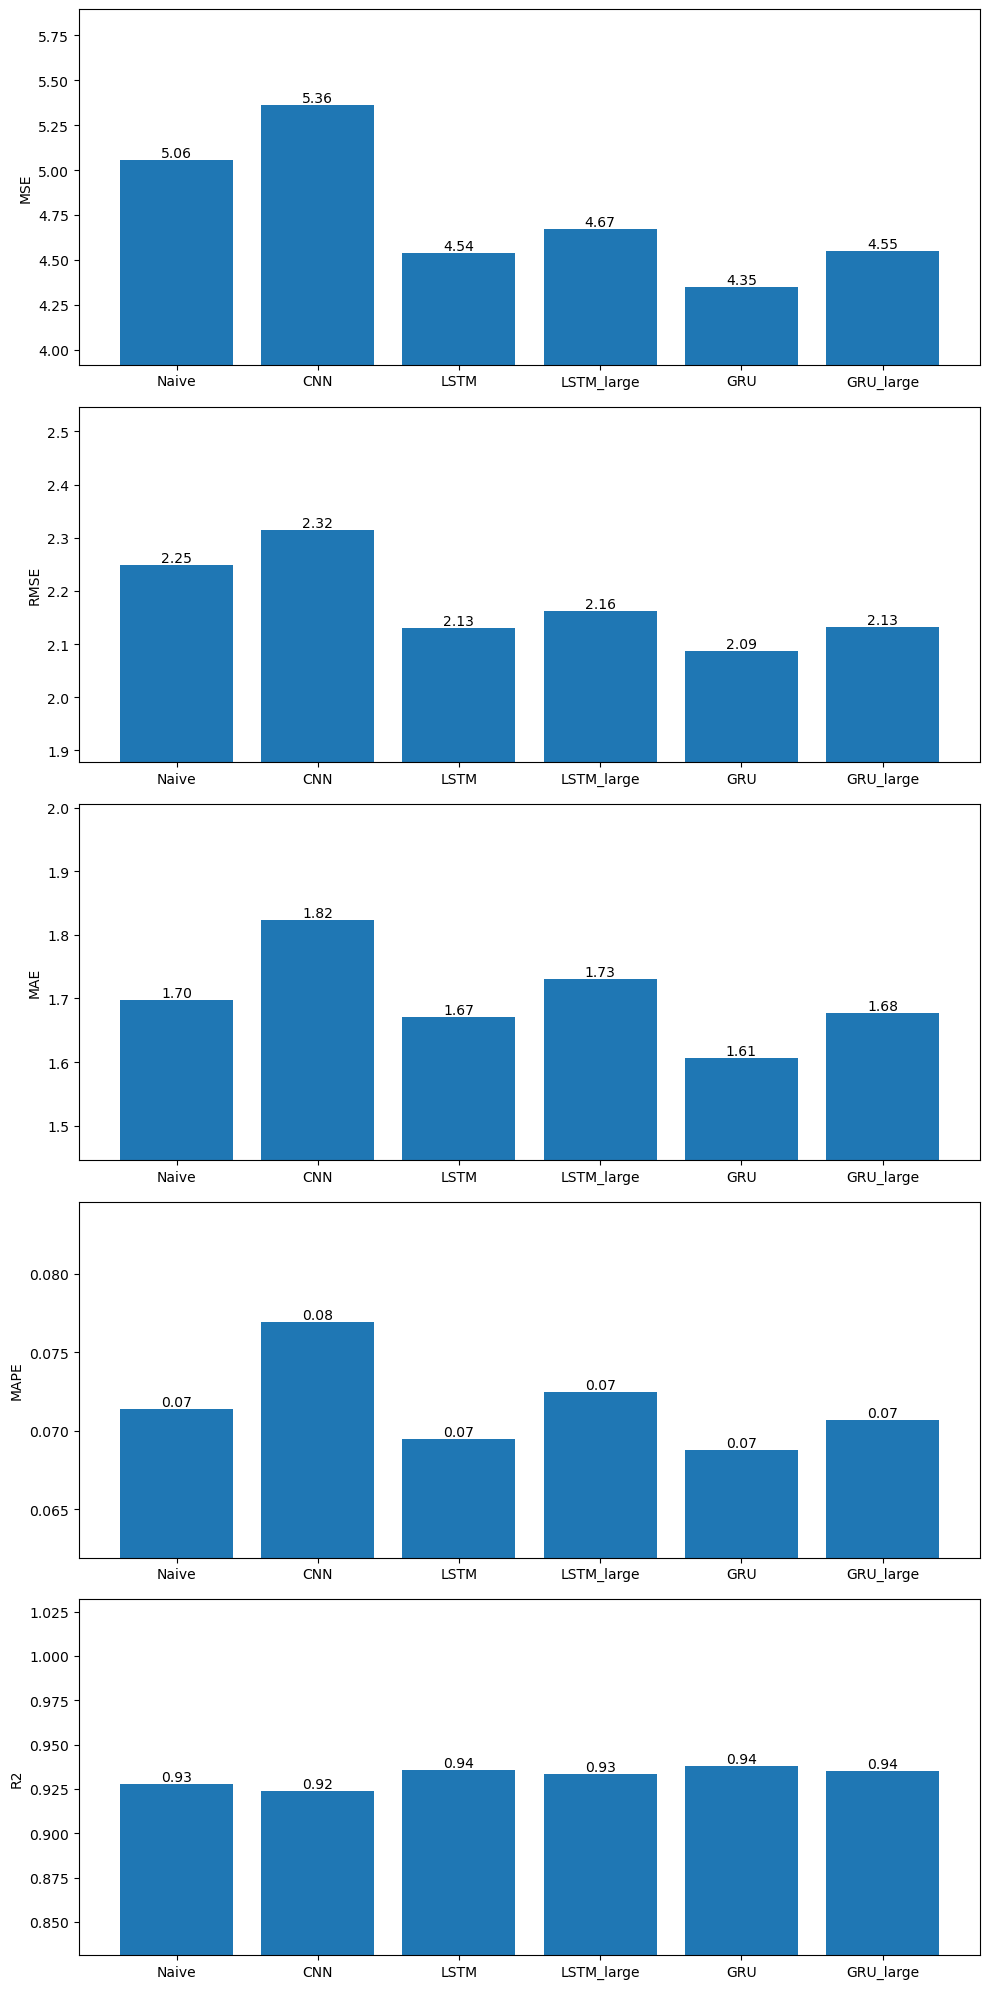

In [85]:
# Datos de los MSE
mse_values = [MSE_naive, MSE_CNN, MSE_LSTM, MSE_LSTM_large, MSE_GRU, MSE_GRU_large]

# Datos de los RMSE
rmse_values = [RMSE_naive, RMSE_CNN, RMSE_LSTM, RMSE_LSTM_large, RMSE_GRU, RMSE_GRU_large]

# Datos de los MAE
mae_values = [MAE_naive, MAE_CNN, MAE_LSTM, MAE_LSTM_large, MAE_GRU, MAE_GRU_large]

# Datos de los MAPE
mape_values = [MAPE_naive, MAPE_CNN, MAPE_LSTM, MAPE_LSTM_large, MAPE_GRU, MAPE_GRU_large]

# Datos de los R2
r2_values = [R2_naive, R2_CNN, R2_LSTM, R2_LSTM_large, R2_GRU, R2_GRU_large]

# Configuración de los subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Diagrama de barras de los MSE
axs[0].bar(range(len(mse_values)), mse_values)
axs[0].set_xticks(range(len(mse_values)))
axs[0].set_xticklabels(['Naive', 'CNN', 'LSTM', 'LSTM_large', 'GRU', 'GRU_large'])
axs[0].set_ylabel('MSE')

# Ajustar el rango del eje y
axs[0].set_ylim(min(mse_values) - 0.1 * abs(min(mse_values)), max(mse_values) + 0.1 * abs(max(mse_values)))

# Agregar etiquetas con los valores de MSE
for i, mse in enumerate(mse_values):
    axs[0].text(i, mse, f'{mse:.2f}', ha='center', va='bottom')

# Diagrama de barras de los RMSE
axs[1].bar(range(len(rmse_values)), rmse_values)
axs[1].set_xticks(range(len(rmse_values)))
axs[1].set_xticklabels(['Naive', 'CNN', 'LSTM', 'LSTM_large', 'GRU', 'GRU_large'])
axs[1].set_ylabel('RMSE')

# Ajustar el rango del eje y
axs[1].set_ylim(min(rmse_values) - 0.1 * abs(min(rmse_values)), max(rmse_values) + 0.1 * abs(max(rmse_values)))

# Agregar etiquetas con los valores de RMSE
for i, rmse in enumerate(rmse_values):
    axs[1].text(i, rmse, f'{rmse:.2f}', ha='center', va='bottom')

# Diagrama de barras de los MAE
axs[2].bar(range(len(mae_values)), mae_values)
axs[2].set_xticks(range(len(mae_values)))
axs[2].set_xticklabels(['Naive', 'CNN', 'LSTM', 'LSTM_large', 'GRU', 'GRU_large'])
axs[2].set_ylabel('MAE')

# Ajustar el rango del eje y
axs[2].set_ylim(min(mae_values) - 0.1 * abs(min(mae_values)), max(mae_values) + 0.1 * abs(max(mae_values)))

# Agregar etiquetas con los valores de MAE
for i, mae in enumerate(mae_values):
    axs[2].text(i, mae, f'{mae:.2f}', ha='center', va='bottom')

# Diagrama de barras de los MAPE
axs[3].bar(range(len(mape_values)), mape_values)
axs[3].set_xticks(range(len(mape_values)))
axs[3].set_xticklabels(['Naive', 'CNN', 'LSTM', 'LSTM_large', 'GRU', 'GRU_large'])
axs[3].set_ylabel('MAPE')

# Ajustar el rango del eje y
axs[3].set_ylim(min(mape_values) - 0.1 * abs(min(mape_values)), max(mape_values) + 0.1 * abs(max(mape_values)))

# Agregar etiquetas con los valores de MAPE
for i, mape in enumerate(mape_values):
    axs[3].text(i, mape, f'{mape:.2f}', ha='center', va='bottom')

# Diagrama de barras de los R2
axs[4].bar(range(len(r2_values)), r2_values)
axs[4].set_xticks(range(len(r2_values)))
axs[4].set_xticklabels(['Naive', 'CNN', 'LSTM', 'LSTM_large', 'GRU', 'GRU_large'])
axs[4].set_ylabel('R2')

# Ajustar el rango del eje y
axs[4].set_ylim(min(r2_values) - 0.1 * abs(min(r2_values)), max(r2_values) + 0.1 * abs(max(r2_values)))

# Agregar etiquetas con los valores de R2
for i, r2 in enumerate(r2_values):
    axs[4].text(i, r2, f'{r2:.2f}', ha='center', va='bottom')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los diagramas de barras
plt.show()
